In [16]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt
import h5py

In [4]:
# IMDB dataset
imdb_dir = '/home/akshaj/projects_python/conda/arena-py3.6/sentiment-analysis/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []


In [5]:
# GLoVE
glove_dir = '/home/akshaj/projects_python/conda/arena-py3.6/sentiment-analysis/data/glove.6B'



In [6]:
# Pre processing

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [7]:
maxlen = 100  # Cut off reviews after 100 words
training_samples = 500  # Train on 500 samples
validation_samples = 10000  # Validate on 10,000 samples
max_words = 10000  # Consider top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)



In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [9]:
# Shuffles and splits the data into a training set and a
# validation set.

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]



In [10]:
# Parsing GLoVE word embedding files
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



In [13]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.summary()

In [14]:
# Load pretrained word embeddings into the Embedding layer
# Freeze the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [17]:
# Compile and train

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))


Train on 500 samples, validate on 10000 samples
Epoch 1/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.9496 - val_acc: 0.5975
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 1.0409 - val_acc: 0.5900
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.0326 - val_acc: 0.5947
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.0546 - val_acc: 0.5982
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 1.0803 - val_acc: 0.5977
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.1120 - val_acc: 0.5946
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.1270 - val_acc: 0.5964
Epoch 8/20
500/500 [========

In [23]:
# import h5py
# model.save_weights('pre_trained_glove_model.h5')

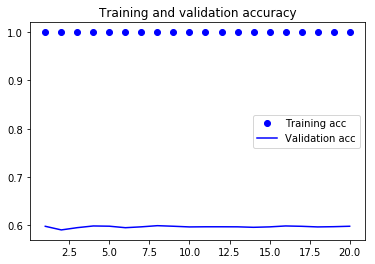

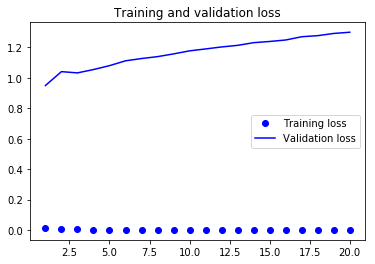

In [24]:
# Plot the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
#  Train the same model without pretrained word embeddings
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Train on 500 samples, validate on 10000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/step - loss: 0.6953 - acc: 0.5220 - val_loss: 0.6909 - val_acc: 0.5289
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 0.4783 - acc: 0.9620 - val_loss: 0.6893 - val_acc: 0.5429
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1909 - acc: 0.9900 - val_loss: 0.6886 - val_acc: 0.5615
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0562 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.5710
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.7044 - val_acc: 0.5752
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.7163 - val_acc: 0.5779
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.7319 - val_acc: 0.5797
Epoch 8/20
500/500 [========

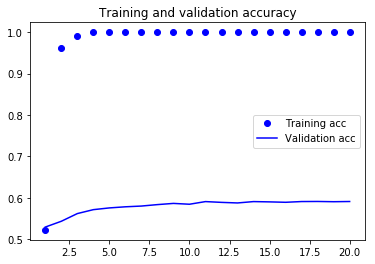

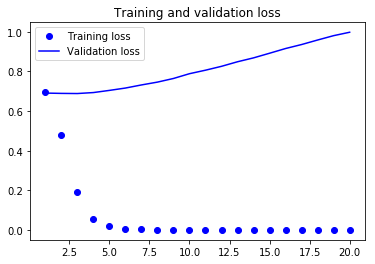

In [26]:
# Plot the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# TEST DATA


# Tokenize test data
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

In [28]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)